## Seminar 10. Introduction to Reinforcement Learning



# Farama Gymnasium (Gym interface)

Before applying Reinforcement Learning algorithms to complex real-world problems, it's often beneficial to test them on simpler environments. [Gymnasium](https://github.com/Farama-Foundation/Gymnasium) (the successor to OpenAI Gym) provides a valuable collection of these environments, including robot control, videogames and board games.

Documentation: https://gymnasium.farama.org/

Let's see how it works.

In [ ]:
!pip install gymnasium

In [ ]:
import numpy as np
import gymnasium as gym
from dataclasses import dataclass
import typing as tt
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Frozen Lake Game

The next environment that we will try to solve using the cross- entropy method is **FrozenLake**.

*   Its world is from the so-called grid world category, when your agent lives in  a grid of size $ 4 \times 4$ and can move in four directions: up, down, left, and right.
*   The agent always starts at the top left, and its goal is to reach the bottom-right cell of the grid.
*  There are **holes** in the fixed cells of the grid and if you get into those holes, the episode ends and your reward is zero.
*  If the agent reaches the **destination cell**, then it obtains a reward of 1.0 and the episode ends.

To make life more complicated, by default the world is slippery, so there is a 33% chance that it will slip to the right or to the left. For simplicity we turn this option off.

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", render_mode="rgb_array", is_slippery=False)
env.reset()

In [ ]:
img = env.render()
plt.imshow(img)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Note: if you're running this on your local machine, you'll see a window pop up with the image above. Don't close it, just alt-tab away.



### Gymnasium interface



The three main methods of an environment are
* `reset()`: reset environment to the initial state, return first observation and dict with auxiliary info
* `render()`: show current environment state (a more colorful version :) )
* `step(a)`: commit action `a` and return `(new_observation, reward, terminated, truncated, info)`
 * `new_observation`: an observation right after committing the action `a`
 * `reward`: a number representing your reward for committing action `a`
 * `terminated`: True if the MDP has just finished, False if still in progress
 * `truncated`: True if the number of steps elapsed >= max episode steps
 * `info`: some auxiliary stuff about what just happened. For now, ignore it.


A detailed explanation of the difference between `terminated` and `truncated` and how it should be used:
1. https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/
2. https://gymnasium.farama.org/content/migration-guide/


In [ ]:
# Set seed to reproduce initial state in stochastic environment
obs0, info = env.reset(seed=0)
print("initial observation code:", obs0)

obs0, info = env.reset(seed=1)
print("initial observation code:", obs0)

Let's make one step.

In [ ]:
print("taking action 2 (right)")
new_obs, reward, terminated, truncated, _ = env.step(2)
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", terminated)
print("is game truncated due to time limit?:", truncated)

To process environment positions, we can use "wrappers" that apply one-hot encoding. This means each position is converted into a vector with a single "1" and the rest "0"s, for example, $$(0, \dots, 0, 1, 0, \dots, 0).$$

In [ ]:
class DiscreteOneHotWrapper(gym.ObservationWrapper):
    def __init__(self, env: gym.Env):
        super(DiscreteOneHotWrapper, self).__init__(env)
        assert isinstance(env.observation_space, gym.spaces.Discrete)
        shape = (env.observation_space.n, )
        self.observation_space = gym.spaces.Box(0.0, 1.0, shape, dtype=np.float32)

    def observation(self, observation):
        res = np.copy(self.observation_space.low)
        res[observation] = 1.0
        return res



### Cross Entropy for Frozen-Lake

Our model is a simple FFNN.

In [ ]:
class Net(nn.Module):
    def __init__(self, obs_size: int, hidden_size: int,
                 n_actions: int):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

We make classes to save episode steps and episodes

In [ ]:
@dataclass
class EpisodeStep:
    observation: np.ndarray
    action: int

@dataclass
class Episode:
    reward: float
    steps: tt.List[EpisodeStep]

A function that generates one batch. Each batch consists of

1. The total `reward` (float).
2. A list of `EpisodeStep`.

Each `EpisodeStep` consists of  

*  `observation` (an array), which describes the state,
*  `action` (int) taken in the state.





In [ ]:
def iterate_batches(env: gym.Env, model: Net, batch_size: int) -> \
        tt.Generator[tt.List[Episode], None, None]:
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs, _ = env.reset()
    softmax = nn.Softmax(dim=1)
    while True:
        # choose an action
        obs_v = torch.tensor(obs, dtype=torch.float32)
        act_probs_v = softmax(model(obs_v.unsqueeze(0)))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)

        # make step, find reward
        next_obs, reward, is_done, is_trunc, _ = env.step(action)
        episode_reward += float(reward)

        # saving the step
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)

        # save episode if it ended
        if is_done or is_trunc:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)

            # reset values
            episode_reward = 0.0
            episode_steps = []
            next_obs, _ = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs

Select `percentile` of best episodes. The function returns:

* `train_obs_v` = tensor of observations with shape $(S,D)$, where $X$ total number of actions (= total length of selected episodes) and $D=16$ is the size of vector for the episode.
* `train_act_v` = tensor of taken action with shape $(S)$.
* `reward_bound` = the reward boundary used for filtering.
* `reward_mean` = the mean reward.

In [ ]:
def filter_batch(batch: tt.List[Episode], percentile: float) -> \
        tt.Tuple[torch.FloatTensor, torch.LongTensor, float, float]:
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = float(np.percentile(rewards, percentile))
    reward_mean = float(np.mean(rewards))

    train_obs: tt.List[np.ndarray] = []
    train_act: tt.List[int] = []
    for episode in batch:
        if episode.reward < reward_bound:
            continue

        train_obs.extend(map(lambda step: step.observation,
                             episode.steps))
        train_act.extend(map(lambda step: step.action,
                             episode.steps))

    train_obs_v = torch.FloatTensor(np.vstack(train_obs))
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean

Parameters of the model

In [ ]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70
MAX_ITER = 2000
LR = 0.01

Application of the model

In [ ]:
env = DiscreteOneHotWrapper(gym.make("FrozenLake-v1", desc=None, map_name="4x4",
                                     render_mode="rgb_array", is_slippery=False))
obs_size = env.observation_space.shape[0]
n_actions = int(env.action_space.n)

net = Net(obs_size, HIDDEN_SIZE, n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=LR)

for iter_no, batch in enumerate(
        iterate_batches(env, net, BATCH_SIZE)):


    # We perform filtering of the elite episodes using the
    # function. The result is tensors of observations and taken actions,
    # the reward boundary used for filtering, and the mean reward.

    obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
    optimizer.zero_grad()

    # calculate action scores
    action_scores_v = net(obs_v)

    # Calculate Cross-Entropy between the NN output and the actions that the agent took.
    # The idea is to reinforce our NN to carry out the elite actions that have led to good rewards.
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()
    if iter_no % 200 == 0:
        print("%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
    if reward_m > 0.8:
        print("Solved!")
        break
    if iter_no > MAX_ITER:
        print("NOT solved!")
        break

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

frames = []

obs = env.reset()
if isinstance(obs, tuple):
    obs = obs[0]

while True:
    # Render before action
    frame = env.render()
    frames.append(frame)

    obs_v = torch.FloatTensor([obs])
    logits = net(obs_v)
    action = torch.argmax(logits, dim=1).item()

    obs, reward, done, *_ = env.step(action)
    if isinstance(obs, tuple):
        obs = obs[0]

    if done:
        # One final render *after* last step
        frame = env.render()
        frames.append(frame)
        break

# Play back all frames
for frame in frames:
    plt.imshow(frame)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.3)

print(f"Episode reward: {reward}")

We can see that our training process *doesn't improve the score over time*.


<font color='red'>Problems.</font>

*   In the FrozenLake environment we get the reward of 1.0 only when we reach the goal, and this reward says nothing about how good each episode was.
*   There are only two kinds of episodes possible, with zero reward (failed) and one reward (successful), and failed episodes will obviously dominate at the beginning of the training, when the agent acts randomly.

This example shows us the <font color='red'>limitations of the cross-entropy method</font> :
1. For training, our episodes have to be finite (in general, they could be infinite) and, preferably, short.
2. The total reward for the episodes should have enough variability to separate good episodes from bad ones.
3. It is beneficial to have an intermediate reward during the episode instead of having the reward at the end of the episode.




## Fixing CE for Frozen Lake (optional)

Troubleshooting RL problems can be extremely challenging, often requiring a lot of "duck tape" and ad hoc modifications.

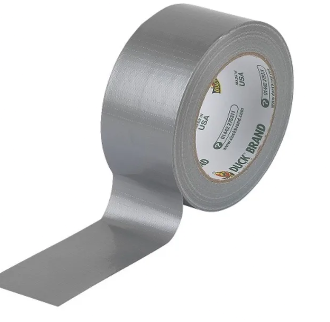

We'll briefly list potential fixes, omitting detailed explanations.

1. Larger batches of played episodes.
2. Discount factor applied to the reward.
3. Keeping elite episodes for a longer time.
4. Decreasing the learning rate.
5. A more complex model.
6. Much longer training time (!).